In [1]:
%load_ext autoreload
%autoreload 2

In [90]:
import scipy.io as sio
import scipy.stats as sio_stat
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

import os
import pickle
import sys
import copy

import time
import pylab as pl
from IPython import display

from bmi_dynamics_code import behavior_co_obs as bmi_b
from bmi_dynamics_code import data_for_v as preeyacode
from bmi_dynamics_code import util as bmi_util

import timeit
from sklearn import decomposition as skl_decomp

import pickle

%matplotlib notebook

In [3]:
home_dir = r'D:\Dropbox\Code\preeya_co_obstacle'
data_dir = home_dir
data_path = os.path.join(data_dir, 'for_v_v4.pkl')
print(os.path.exists(data_path))
data = pickle.load(open(data_path))

save_dir = r'D:\Dropbox\Data\preeya_co_obstacle'

True


In [4]:
data.keys()

[(4378, 'decC'),
 (4382, 'decW'),
 (4377, 'trial_ix'),
 (4377, 'dec_KG'),
 (4377, 'cursor_state'),
 (4378, 'decW'),
 (4378, 'decQ'),
 (4378, 'dec_KG'),
 (4378, 'target_index'),
 (4377, 'decC'),
 (4378, 'trial_ix'),
 (4377, 'decQ'),
 (4377, 'neural_push'),
 (4377, 'binned_spk_cnts'),
 (4378, 'obstacle_size'),
 (4382, 'decQ'),
 (4382, 'dec_KG'),
 (4382, 'decF'),
 (4378, 'cursor_state'),
 (4382, 'binned_spk_cnts'),
 (4378, 'binned_spk_cnts_60Hz'),
 (4378, 'decA'),
 (4382, 'target_pos'),
 (4377, 'decF'),
 (4382, 'decC'),
 'task_entries',
 (4382, 'target_index'),
 (4378, 'cursor_pos'),
 (4382, 'binned_spk_cnts_60Hz'),
 (4377, 'decA'),
 (4377, 'binned_spk_cnts_60Hz'),
 (4377, 'target_index'),
 (4382, 'trial_ix'),
 (4378, 'decF'),
 (4377, 'cursor_pos'),
 (4382, 'neural_push'),
 (4382, 'obstacle_location'),
 (4382, 'obstacle_size'),
 (4377, 'target_pos'),
 (4382, 'cursor_pos'),
 (4377, 'decW'),
 (4378, 'neural_push'),
 (4382, 'cursor_state'),
 (4378, 'target_pos'),
 (4378, 'binned_spk_cnts'),


### decoder variables: 
decC
decW
decQ
dec_KG
decF
decA

### analysis variables: 
cursor_state
cursor_pos
neural_push
binned_spk_cnts

### indexing variables:
tc
target_index
trial_ix
--bin_idx

### aux variables: 
obstacle_location
obstacle_size
target_pos

In [ ]:
#distinct data types: 
# decC
# decW
# decQ
# dec_KG
# trial_ix
# target_index
# target_pos
#
# cursor_state
# neural_push
# binned_spk_cnts
# binned_spk_cnts_60Hz

# obstacle_size
# shape: num_trials x 1
# each trial is either 2 or 3
#
# obstacle_location
# shape: num_trials x 1
# each trial is either 2 or 3

In [5]:
#Map between Task Code (tc) and Task {'co', 'obs'}
#DATA: 
#task_list
#task2tc
#tc_list
#tc2task

task_list = ['co', 'obs']
task2idx = {'co':0, 'obs':1}
task2tc = {'co':data['task_entries'][0], 'obs':data['task_entries'][1]}
tc_list = [item for sublist in data['task_entries'] for item in sublist]
tc2task = {}
for k,v_list in task2tc.items():
    for v in v_list:
        tc2task[v] = k
print(tc_list)
print(tc2task)

[4377, 4378, 4382]
{4377: 'co', 4378: 'obs', 4382: 'obs'}


In [7]:
#Data: 
#num_targets
#sample_period
#target_hold_Time
#num_neurons
#target_color
#tc_meta

num_targets = 8
sample_period = 0.1 #seconds
target_hold_time = 0.2 #seconds
num_neurons = data[tc_list[0], 'binned_spk_cnts'][1].shape[1]

tc_meta = {}

task2data_list = {}
task2data_list['co'] = ['cursor_pos', 'cursor_state', 'neural_push',  'binned_spk_cnts']
task2data_list['obs'] = ['cursor_pos', 'cursor_state', 'neural_push',  'binned_spk_cnts', 'obstacle_size', 'obstacle_location']
target_color = ['maroon', 'orangered', 'darkgoldenrod', 'olivedrab', 'teal', 'steelblue', 'midnightblue', 'darkmagenta']

collect_trials = False
tc_trials = {}

for tc in tc_list: 
    task = tc2task[tc]
    tc_meta[tc] = {}
    tc_trials[tc] = []
    
    num_trials = int(data[tc, 'trial_ix'].max()+1)
    ttype = np.array([data[tc, 'target_index'][np.where(data[tc, 'trial_ix'] == i_trial)[0][0]] for i_trial in range(num_trials)]).astype(int)
    target_pos = np.array([data[tc, 'target_pos'][np.where(data[tc, 'target_index'] == i_target)[0][0], :] for i_target in range(num_targets)])
    num_trials_per_target = [np.sum(ttype==i) for i in range(num_targets)]
    target_trial_idxs = {}
    for i in range(num_targets):
        target_trial_idxs[i] = np.where(ttype==i)[0]
    if task == 'obs':
        #obs_pos: one obs position per target
        obs_pos = np.array([data[tc, 'obstacle_location'][target_trial_idxs[i][0], :] for i in range(num_targets)])
        #obs_size_per_target: for each target, an array of obstacle size
        obs_size_per_target_trial = [data[tc, 'obstacle_size'][target_trial_idxs[i],:] for i in range(num_targets)]
    #for each target, what are the obstacle sizes
    
    if collect_trials:
        #Loop trials: 
        for i in range(num_trials):
            trial_data = {}
            for d in task2data_list[tc2task[tc]]:
                trial_data[d] = np.array(data[tc, d][i])
            #time of trial: 
            trial_data['len'] = sample_period*trial_data['cursor_pos'].shape[0]
            tc_trials[tc].append(trial_data)
    
    #ASSIGN:
    tc_meta[tc]['task'] = tc2task[tc]
    tc_meta[tc]['ttype'] = ttype
    tc_meta[tc]['target_pos'] = target_pos
    if task == 'obs':
        tc_meta[tc]['obs_pos'] = obs_pos
        tc_meta[tc]['obs_size_per_target_trial'] = obs_size_per_target_trial
    tc_meta[tc]['num_trials'] = num_trials
    tc_meta[tc]['num_trials_per_target'] = num_trials_per_target
    tc_meta[tc]['target_trial_idxs'] = target_trial_idxs
    tc_meta[tc]['sample_period'] = sample_period
    tc_meta[tc]['target_hold'] = target_hold_time
#TODO: add the times of trials in the meta above

In [84]:
tc_meta

{4377: {'num_trials': 64,
  'num_trials_per_target': [8, 8, 8, 8, 8, 8, 8, 8],
  'sample_period': 0.1,
  'target_hold': 0.2,
  'target_pos': array([[-7.07106781e+00, -7.07106781e+00],
         [-1.83697020e-15, -1.00000000e+01],
         [ 7.07106781e+00, -7.07106781e+00],
         [ 1.00000000e+01,  0.00000000e+00],
         [ 7.07106781e+00,  7.07106781e+00],
         [ 6.12323400e-16,  1.00000000e+01],
         [-7.07106781e+00,  7.07106781e+00],
         [-1.00000000e+01,  1.22464680e-15]]),
  'target_trial_idxs': {0: array([ 0, 12, 16, 24, 38, 46, 51, 56], dtype=int64),
   1: array([ 1, 14, 21, 31, 34, 42, 49, 57], dtype=int64),
   2: array([ 3, 13, 22, 25, 36, 43, 53, 61], dtype=int64),
   3: array([ 6, 10, 19, 29, 33, 40, 50, 58], dtype=int64),
   4: array([ 2, 11, 18, 28, 37, 47, 54, 60], dtype=int64),
   5: array([ 4,  9, 23, 30, 39, 45, 52, 59], dtype=int64),
   6: array([ 7,  8, 17, 27, 32, 41, 48, 63], dtype=int64),
   7: array([ 5, 15, 20, 26, 35, 44, 55, 62], dtype=int64)

In [8]:
#Decoder:
decoder = {}
tc = 4377 #the decoder is the same for all tc
decoder['A'] = np.array(data[4377, 'decA'])
decoder['C'] = np.array(data[4377, 'decC'])
decoder['W'] = np.array(data[4377, 'decW'])
decoder['Q'] = np.array(data[4377, 'decQ'])
decoder['K'] = np.array(data[4377, 'dec_KG'])
decoder['F'] = np.array(data[4377, 'decF'])

# decC
# decW
# decQ
# dec_KG
# decF
# decA

In [ ]:
#task_list
#task2tc
#tc_list
#tc2task

#num_targets
#sample_period
#target_hold_Time
#num_neurons
#target_color
#tc_meta

#decoder

In [16]:
# tc = task2tc['co'][0]
tc = task2tc['obs'][0]
tc_meta[tc]['target_trial_idxs']

{0: array([ 9, 11, 17, 23, 37, 47, 50, 51, 67, 76, 87, 91, 97], dtype=int64),
 1: array([ 4, 10, 25, 29, 35, 45, 56, 57, 68, 77, 94, 95], dtype=int64),
 2: array([  7,   8,  19,  30,  38,  43,  48,  49,  65,  72,  84,  86,  96,
        100], dtype=int64),
 3: array([ 5, 13, 26, 27, 39, 44, 53, 55, 70, 73, 80, 93], dtype=int64),
 4: array([ 2, 15, 22, 24, 40, 46, 54, 63, 69, 74, 89, 90, 98], dtype=int64),
 5: array([ 0, 12, 18, 21, 34, 41, 59, 62, 64, 78, 82, 92], dtype=int64),
 6: array([ 1,  6, 16, 31, 32, 42, 60, 61, 75, 79, 83, 85], dtype=int64),
 7: array([ 3, 14, 20, 28, 33, 36, 52, 58, 66, 71, 81, 88, 99], dtype=int64)}

In [69]:
#Indexing:
# tc
# task
# target
# trial
# bin
#
#Analysis: 
# binned_spk_cnts
# neural_push
# cursor_state

#---------------------------------------------------------------------------------
#Labels for data: 
#n: binned_spk_cnts
#u: neural_push
#kin: cursor_state
label = {}
label['n'] = ['n_'+str(i) for i in range(num_neurons)]
label['u'] = ['px', 'py', 'vx', 'vy']
label['u'] = ['u_'+k for k in label['u']]
label['kin'] = ['px', 'py', 'vx', 'vy']
label['kin'] = ['kin_'+k for k in label['kin']]
# print('printing labels:')
# print(label['n'])
# print(label['u'])
# print(label['kin'])
# print('labels printed')

#task, tc, target, trials, make bin
pre = 10
# i_list = ['tc', 'task', 'target', 'trial', 'bin']
# d_list = ['cursor_state', 'cursor_pos', 'neural_push', 'binned_spk_cnts']

#Loop: task, tc, target, trial
min_num_samples = 1
init_df = True #need to initialize
data_ctr = 0
t_start = timeit.default_timer()
for task in task_list: #['co']:
    for tc in task2tc[task]:
        for target in range(num_targets): #[0]:
            for trial in tc_meta[tc]['target_trial_idxs'][target]: #[0,1,2]:
                print(task, tc, target, trial)
                #analysis: n, ctrl, kin
                n = data[tc, 'binned_spk_cnts'][trial]
                u = data[tc, 'neural_push'][trial]
                kin = data[tc, 'cursor_state'][trial]
                num_data = n.shape[0]
                if num_data > min_num_samples: 
                    #index for dataframe: 
                    i = data_ctr + np.arange(0,num_data)
                    data_ctr += num_data
                    #data frames:
                    df_data = pd.DataFrame(np.hstack((n,u,kin)), index=i, columns=label['n']+label['u']+label['kin'])
                    #indexing data: 
                    df_idx = bmi_util.make_df_idx(i, task2idx[task], tc, target, trial, pre, num_data)                
                    df_i = pd.concat([df_data, df_idx], axis=1)
    #                 df_i = df_data
                    if init_df: 
                        df = df_i
                        init_df = False
                    else:
                        df = pd.concat([df, df_i], axis=0)
t_elapsed = timeit.default_timer()-t_start
print('time elapsed:', t_elapsed)

('co', 4377, 0, 0)
('co', 4377, 0, 12)
('co', 4377, 0, 16)
('co', 4377, 0, 24)
('co', 4377, 0, 38)
('co', 4377, 0, 46)
('co', 4377, 0, 51)
('co', 4377, 0, 56)
('co', 4377, 1, 1)
('co', 4377, 1, 14)
('co', 4377, 1, 21)
('co', 4377, 1, 31)
('co', 4377, 1, 34)
('co', 4377, 1, 42)
('co', 4377, 1, 49)
('co', 4377, 1, 57)
('co', 4377, 2, 3)
('co', 4377, 2, 13)
('co', 4377, 2, 22)
('co', 4377, 2, 25)
('co', 4377, 2, 36)
('co', 4377, 2, 43)
('co', 4377, 2, 53)
('co', 4377, 2, 61)
('co', 4377, 3, 6)
('co', 4377, 3, 10)
('co', 4377, 3, 19)
('co', 4377, 3, 29)
('co', 4377, 3, 33)
('co', 4377, 3, 40)
('co', 4377, 3, 50)
('co', 4377, 3, 58)
('co', 4377, 4, 2)
('co', 4377, 4, 11)
('co', 4377, 4, 18)
('co', 4377, 4, 28)
('co', 4377, 4, 37)
('co', 4377, 4, 47)
('co', 4377, 4, 54)
('co', 4377, 4, 60)
('co', 4377, 5, 4)
('co', 4377, 5, 9)
('co', 4377, 5, 23)
('co', 4377, 5, 30)
('co', 4377, 5, 39)
('co', 4377, 5, 45)
('co', 4377, 5, 52)
('co', 4377, 5, 59)
('co', 4377, 6, 7)
('co', 4377, 6, 8)
('co', 43

In [114]:
tc_list

[4377, 4378, 4382]

In [117]:
task2idx

{'co': 0, 'obs': 1}

In [118]:
#Make a dictionary and save it: 

data_df = {}
data_df['pre'] = pre
data_df['num_targets'] = num_targets
data_df['sample_period'] = sample_period
data_df['target_hold_time'] = target_hold_time
data_df['num_neurons'] = num_neurons
data_df['target_color'] = target_color
data_df['obs_big'] = 3
data_df['obs_small'] = 2
data_df['target_r'] = 2
data_df['target_pos'] = tc_meta[tc_list[0]]['target_pos']
data_df['obs_pos'] = tc_meta[task2tc['obs'][0]]['obs_pos']

data_df['tc_meta'] = tc_meta
data_df['task_list'] = task_list
data_df['task2idx'] = task2idx
data_df['task2tc'] = task2tc
data_df['tc_list'] = tc_list
data_df['df'] = df
data_df['df_label'] = label


#SAVE: 
save_path = os.path.join(save_dir, 'for_v_df.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(data_df, f)

#num_targets
#sample_period
#target_hold_time
#num_neurons
#target_color
#tc_meta
#df
#label
#pre

In [108]:
#Test load: 
test = pickle.load(open(save_path, 'rb')) 

In [111]:
test['df'].head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_vy,kin_px,kin_py,kin_vx,kin_vy,task,tc,target,trial,bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,0.926157,6.364384,5.734679,0.323774,1.004399,0.0,4377.0,0.0,12.0,-10.0
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,2.485502,6.462141,6.041918,0.912812,2.871518,0.0,4377.0,0.0,12.0,-9.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.376951,6.612443,6.369001,1.320459,2.696526,0.0,4377.0,0.0,12.0,-8.0
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,-0.867829,6.719260,6.459357,0.804078,0.364251,0.0,4377.0,0.0,12.0,-7.0
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.026056,6.832780,6.575842,0.974384,1.091997,0.0,4377.0,0.0,12.0,-6.0


In [85]:
tc_meta

{4377: {'num_trials': 64,
  'num_trials_per_target': [8, 8, 8, 8, 8, 8, 8, 8],
  'sample_period': 0.1,
  'target_hold': 0.2,
  'target_pos': array([[-7.07106781e+00, -7.07106781e+00],
         [-1.83697020e-15, -1.00000000e+01],
         [ 7.07106781e+00, -7.07106781e+00],
         [ 1.00000000e+01,  0.00000000e+00],
         [ 7.07106781e+00,  7.07106781e+00],
         [ 6.12323400e-16,  1.00000000e+01],
         [-7.07106781e+00,  7.07106781e+00],
         [-1.00000000e+01,  1.22464680e-15]]),
  'target_trial_idxs': {0: array([ 0, 12, 16, 24, 38, 46, 51, 56], dtype=int64),
   1: array([ 1, 14, 21, 31, 34, 42, 49, 57], dtype=int64),
   2: array([ 3, 13, 22, 25, 36, 43, 53, 61], dtype=int64),
   3: array([ 6, 10, 19, 29, 33, 40, 50, 58], dtype=int64),
   4: array([ 2, 11, 18, 28, 37, 47, 54, 60], dtype=int64),
   5: array([ 4,  9, 23, 30, 39, 45, 52, 59], dtype=int64),
   6: array([ 7,  8, 17, 27, 32, 41, 48, 63], dtype=int64),
   7: array([ 5, 15, 20, 26, 35, 44, 55, 62], dtype=int64)

In [21]:
df.columns

Index([u'n_0', u'n_1', u'n_2', u'n_3', u'n_4', u'n_5', u'n_6', u'n_7', u'n_8',
       u'n_9', u'n_10', u'n_11', u'n_12', u'n_13', u'n_14', u'n_15', u'n_16',
       u'n_17', u'n_18', u'n_19', u'n_20', u'n_21', u'n_22', u'n_23', u'n_24',
       u'n_25', u'n_26', u'n_27', u'n_28', u'n_29', u'n_30', u'n_31', u'n_32',
       u'n_33', u'n_34', u'n_35', u'n_36', u'n_37', u'n_38', u'n_39', u'n_40',
       u'n_41', u'n_42', u'n_43', u'u_px', u'u_py', u'u_vx', u'u_vy',
       u'kin_px', u'kin_py', u'kin_vx', u'kin_vy', u'task', u'tc', u'target',
       u'trial', u'bin'],
      dtype='object')

In [86]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,u_vy,kin_px,kin_py,kin_vx,kin_vy,task,tc,target,trial,bin
0,2.0,1.0,0.0,0.0,1.0,4.0,2.0,0.0,0.0,0.0,...,0.926157,6.364384,5.734679,0.323774,1.004399,0.0,4377.0,0.0,12.0,-10.0
1,2.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,...,2.485502,6.462141,6.041918,0.912812,2.871518,0.0,4377.0,0.0,12.0,-9.0
2,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,1.376951,6.612443,6.369001,1.320459,2.696526,0.0,4377.0,0.0,12.0,-8.0
3,5.0,0.0,0.0,1.0,0.0,4.0,4.0,0.0,0.0,0.0,...,-0.867829,6.719260,6.459357,0.804078,0.364251,0.0,4377.0,0.0,12.0,-7.0
4,4.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,...,1.026056,6.832780,6.575842,0.974384,1.091997,0.0,4377.0,0.0,12.0,-6.0


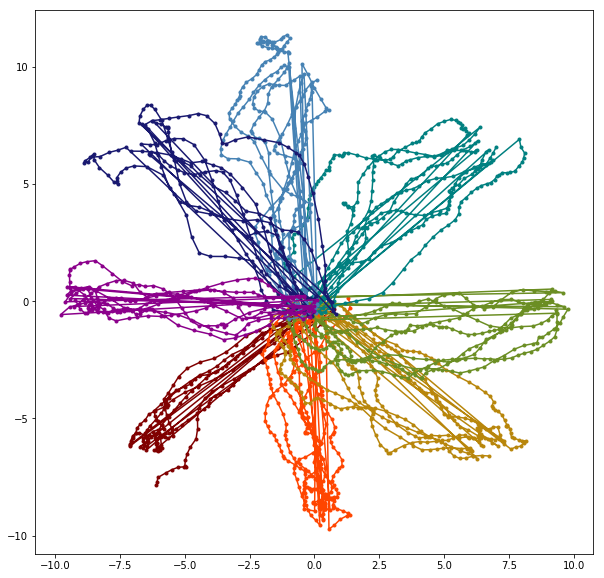

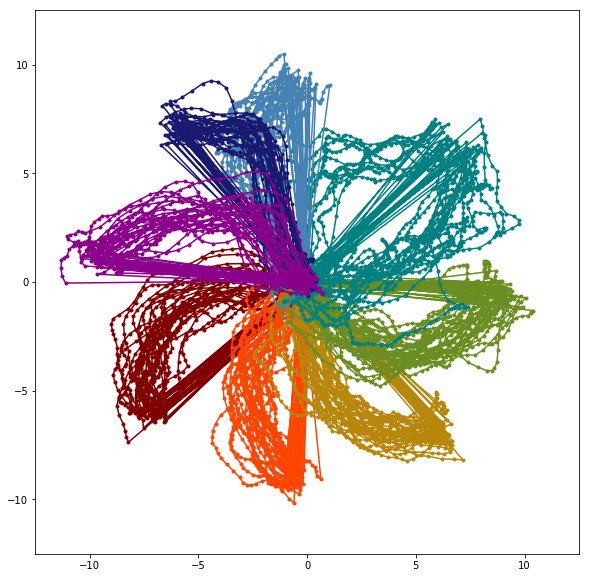

In [74]:
#PLOT DATA: 
plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        x = df['kin_px'][sel]
        y = df['kin_py'][sel]
        color = target_color[target]
        plt.plot(x,y,'.-',color=color)
plt.axis('square')
plt.xlim(plot['xlim'])
plt.ylim(plot['ylim'])
plt.show()


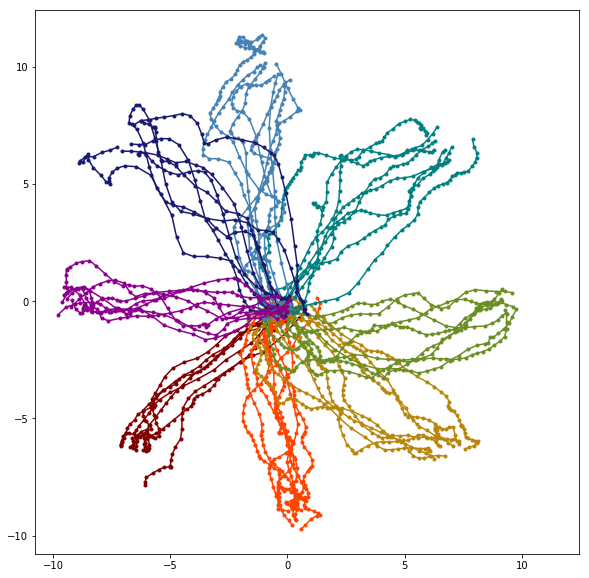

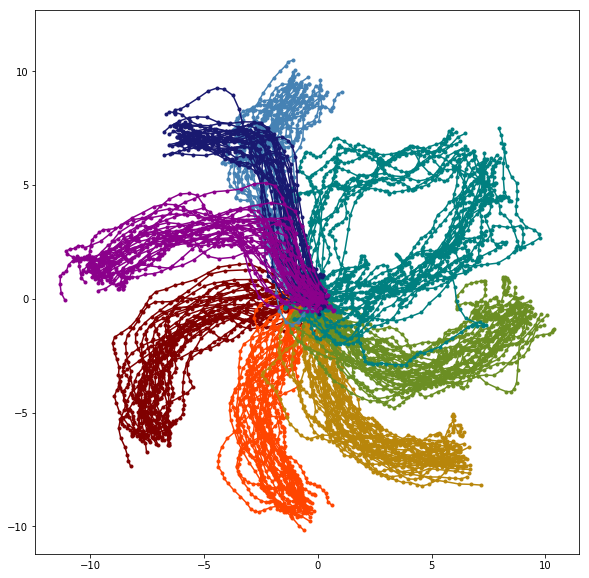

In [83]:
#PLOT INDIVIDUAL TRIALS: 
plot={}
plot['size'] = (10,10)
plot['xlim'] = (-12.5,12.5)
plot['ylim'] = (-12.5,12.5)

for task_str in task_list:
    task = task2idx[task_str]
    plt.figure(figsize=plot['size'])
    for target in range(num_targets):
        sel = (df['task']==task) & (df['bin']>=0) & (df['target']==target)
        df_sel = df[sel]

        #------------------------------------------------------------------------------------
        #TRIALS: 
        trial_start = np.where(df_sel['bin']==0)[0]
        trial_stop = np.hstack((trial_start[1:]-1, len(np.where(sel)[0])))
        trial_bound = np.vstack((trial_start,trial_stop)).T
#         print(trial_bound)
        #------------------------------------------------------------------------------------
        for bnd in trial_bound[:,:]: #trial_bound[0:1,:]:
            x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
            y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
#             print(x)
            color = target_color[target]
            plt.plot(x,y,'.-',color=color)
        
#             x = df_sel['kin_px'][bnd[0]:bnd[1]+1]
#             y = df_sel['kin_py'][bnd[0]:bnd[1]+1]
#             color = target_color[target]
#             plt.plot(x,y,'.-',color=color)        
    plt.axis('square')
#     plt.xlim(plot['xlim'])
#     plt.ylim(plot['ylim'])
    plt.show()


In [41]:
np.hstack((trial_idxs[1:], len(np.where(sel)[0])))

array([ 47,  81, 114, 138, 171, 205, 238], dtype=int64)

In [42]:
trial_bound = np.vstack((trial_idxs, np.hstack((trial_idxs[1:], len(np.where(sel)[0])))))

In [43]:
trial_bound

array([[  0,  47,  81, 114, 138, 171, 205],
       [ 47,  81, 114, 138, 171, 205, 238]], dtype=int64)

In [35]:
trial_idxs

array([  0,  47,  81, 114, 138, 171, 205], dtype=int64)

In [15]:
df['target'].min()

0.0

In [18]:
#How much data is in co: 
len(df[(df['task']==0) & (df['bin']>=0)])

#how much data for each target: 
for target in range(num_targets):
    print(target, len(df[(df['task']==0) & (df['bin']>=0) & (df['target']==target)]))

(0, 238)
(1, 369)
(2, 351)
(3, 353)
(4, 340)
(5, 303)
(6, 221)
(7, 258)


In [ ]:
#Plot trials: 


In [20]:
len(data[4377, 'neural_push'])

64

In [22]:
data[4377, 'neural_push'][1].shape

(56L, 4L)

In [17]:
data[4377, 'binned_spk_cnts'][1].shape

(56L, 44L)

In [29]:

print(num_kin)

4


In [38]:
#TEST CONCAT neural data
#-------------------------------------------------------------------------
num_neurons = data[tc_list[0], 'binned_spk_cnts'][1].shape[1]
num_kin = data[tc_list[0], 'cursor_state'][1].shape[1]
num_ctrl = data[tc_list[0], 'neural_push'][1].shape[1]

label = {}
label['n'] = ['n_'+str(i) for i in range(num_neurons)]
# label['k'] = 
print(label['n'])

m1 = np.array(data[4377, 'binned_spk_cnts'][1])
i1 = np.arange(m1.shape[0])
m2 = np.array(data[4377, 'binned_spk_cnts'][2])
i2 = np.arange(m2.shape[0])+i1[-1]
print(m1.shape)
print(m2.shape)

df1 = pd.DataFrame(m1, index=i1, columns=label['n'])
df2 = pd.DataFrame(m2, index=i2, columns=label['n'])
#rename the columns: 
df = pd.concat([df1, df2])

['n_0', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12', 'n_13', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']
(56L, 44L)
(41L, 44L)


In [77]:
df.head(5)

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_38,n_39,n_40,n_41,n_42,n_43,k_0,k_1,k_2,k_3
0,6.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,1.0,2.0,0.0,6.0,2.0,1.0,-6.146314,-6.124437,-1.162234,-1.616780
1,2.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,0.0,...,1.0,2.0,2.0,5.0,3.0,0.0,-6.317017,-6.372996,-1.474577,-2.162242
2,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,3.0,2.0,1.0,-6.343240,-6.593671,0.032685,-1.774293
3,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,...,6.0,2.0,4.0,10.0,1.0,1.0,-6.250584,-6.747400,0.920025,-1.182438
4,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,5.0,3.0,3.0,5.0,0.0,2.0,-6.218687,-6.886867,0.134959,-1.158178


In [46]:
#TEST joining neural and kinematic data:
#-------------------------------------------------------------------------
num_neurons = data[tc_list[0], 'binned_spk_cnts'][1].shape[1]
num_kin = data[tc_list[0], 'cursor_state'][1].shape[1]

label = {}
label['n'] = ['n_'+str(i) for i in range(num_neurons)]
label['k'] = ['k_'+str(i) for i in range(num_kin)] 
#ToDo: put the correct kinematic labels

n1 = np.array(data[4377, 'binned_spk_cnts'][1])
k1 = np.array(data[4377, 'cursor_state'][1])
i1 = np.arange(m1.shape[0])

df1 = pd.DataFrame(n1, index=i1, columns=label['n'])
df2 = pd.DataFrame(k1, index=i1, columns=label['k'])

df = pd.concat([df1, df2], axis=1)


In [49]:
df.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_38,n_39,n_40,n_41,n_42,n_43,k_0,k_1,k_2,k_3
0,6.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,1.0,2.0,0.0,6.0,2.0,1.0,-6.146314,-6.124437,-1.162234,-1.616780
1,2.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,0.0,...,1.0,2.0,2.0,5.0,3.0,0.0,-6.317017,-6.372996,-1.474577,-2.162242
2,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,3.0,0.0,3.0,3.0,2.0,1.0,-6.343240,-6.593671,0.032685,-1.774293
3,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,...,6.0,2.0,4.0,10.0,1.0,1.0,-6.250584,-6.747400,0.920025,-1.182438
4,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,5.0,3.0,3.0,5.0,0.0,2.0,-6.218687,-6.886867,0.134959,-1.158178


In [44]:
df2.head()

,k_0,k_1,k_2,k_3
0,-6.146314,-6.124437,-1.162234,-1.616780
1,-6.317017,-6.372996,-1.474577,-2.162242
2,-6.343240,-6.593671,0.032685,-1.774293
3,-6.250584,-6.747400,0.920025,-1.182438
4,-6.218687,-6.886867,0.134959,-1.158178


In [50]:
df1.head()

,n_0,n_1,n_2,n_3,n_4,n_5,n_6,n_7,n_8,n_9,...,n_34,n_35,n_36,n_37,n_38,n_39,n_40,n_41,n_42,n_43
0,6.0,1.0,0.0,0.0,1.0,3.0,2.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,2.0,0.0,6.0,2.0,1.0
1,2.0,0.0,0.0,0.0,0.0,4.0,1.0,2.0,0.0,0.0,...,1.0,3.0,1.0,1.0,1.0,2.0,2.0,5.0,3.0,0.0
2,3.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,3.0,2.0,3.0,0.0,3.0,3.0,2.0,1.0
3,1.0,0.0,0.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,3.0,4.0,6.0,2.0,4.0,10.0,1.0,1.0
4,5.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,3.0,5.0,4.0,5.0,3.0,3.0,5.0,0.0,2.0


In [ ]:
# #Test concatenating dataframes
# df1 = pd.DataFrame({'A':['A0', 'A1'],
#                    'B':['B0', 'B1']},
#                   index=[0,1])
# df2 = pd.DataFrame({'A':['A2', 'A3'],
#                    'B':['B2', 'B3']},
#                   index=[2,3])
# frames = [df1, df2]
# result = pd.concat(frames)
# print(df1)
# print(df2)
# print(result)

In [57]:
label = {}
label['n'] = ['n_'+str(i) for i in range(num_neurons)]
label['u'] = ['px', 'py', 'vx', 'vy']
label['u'] = ['u_'+k for k in label['u']]
label['kin'] = ['px', 'py', 'vx', 'vy']
label['kin'] = ['kin_'+k for k in label['kin']]

print(label['n'])
print(label['u'])
print(label['kin'])

['n_0', 'n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6', 'n_7', 'n_8', 'n_9', 'n_10', 'n_11', 'n_12', 'n_13', 'n_14', 'n_15', 'n_16', 'n_17', 'n_18', 'n_19', 'n_20', 'n_21', 'n_22', 'n_23', 'n_24', 'n_25', 'n_26', 'n_27', 'n_28', 'n_29', 'n_30', 'n_31', 'n_32', 'n_33', 'n_34', 'n_35', 'n_36', 'n_37', 'n_38', 'n_39', 'n_40', 'n_41', 'n_42', 'n_43']
['u_px', 'u_py', 'u_vx', 'u_vy']
['kin_px', 'kin_py', 'kin_vx', 'kin_vy']


In [59]:
#function: make_df_idx
num_data = 20
m_task = np.ones(num_data)*task2idx[task]
m_tc = np.ones(num_data)*tc
m_target = np.ones(num_data)*target
m_trial = np.ones(num_data)*trial
m_bin = np.arange(num_data)-pre


In [70]:
test = np.stack((m_task, m_tc, m_target, m_trial, m_bin), axis=1)
test.shape

(20L, 5L)

AttributeError: 'int' object has no attribute 'shape'

In [75]:
i = range(num_data)
df_idx = bmi_util.make_df_idx(i, task2idx[task], tc, target, trial, pre, num_data)

In [76]:
df_idx

,task,tc,target,trial,bin
0,1.0,4382.0,7.0,106.0,-8.0
1,1.0,4382.0,7.0,106.0,-7.0
2,1.0,4382.0,7.0,106.0,-6.0
3,1.0,4382.0,7.0,106.0,-5.0
4,1.0,4382.0,7.0,106.0,-4.0
5,1.0,4382.0,7.0,106.0,-3.0
6,1.0,4382.0,7.0,106.0,-2.0
7,1.0,4382.0,7.0,106.0,-1.0
8,1.0,4382.0,7.0,106.0,0.0
9,1.0,4382.0,7.0,106.0,1.0


In [80]:
n.shape

(1L, 44L)

In [82]:
u.shape

(1L, 4L)

In [86]:
test = np.hstack((n,u))
test.shape

(1L, 48L)

In [94]:
n.shape

(40L, 44L)

In [95]:
test = np.hstack((n,u,kin))
test.shape

(40L, 52L)

In [96]:
label['u']+label['kin']

['u_px', 'u_py', 'u_vx', 'u_vy', 'kin_px', 'kin_py', 'kin_vx', 'kin_vy']

In [9]:
#Indexing:
# tc
# task
# target
# trial
# bin
#
#Analysis: 
# binned_spk_cnts
# neural_push
# cursor_state

#---------------------------------------------------------------------------------
#Labels for data: 
#n: binned_spk_cnts
#u: neural_push
#kin: cursor_state
label = {}
label['n'] = ['n_'+str(i) for i in range(num_neurons)]
label['u'] = ['px', 'py', 'vx', 'vy']
label['u'] = ['u_'+k for k in label['u']]
label['kin'] = ['px', 'py', 'vx', 'vy']
label['kin'] = ['kin_'+k for k in label['kin']]
# print('printing labels:')
# print(label['n'])
# print(label['u'])
# print(label['kin'])
# print('labels printed')

#task, tc, target, trials, make bin
pre = 8
# i_list = ['tc', 'task', 'target', 'trial', 'bin']
# d_list = ['cursor_state', 'cursor_pos', 'neural_push', 'binned_spk_cnts']

#Loop: task, tc, target, trial
min_num_samples = 1
init_df = True #need to initialize
data_ctr = 0
t_start = timeit.default_timer()
for task in task_list: #['co']:
    for tc in task2tc[task]:
        for target in range(num_targets): #[0]:
            for trial in tc_meta[tc]['target_trial_idxs'][target]: #[0,1,2]:
                print(task, tc, target, trial)
                #analysis: n, ctrl, kin
                n = data[tc, 'binned_spk_cnts'][trial]
                u = data[tc, 'neural_push'][trial]
                kin = data[tc, 'cursor_state'][trial]
                num_data = n.shape[0]
                if num_data > min_num_samples: 
                    #index for dataframe: 
                    i = data_ctr + np.arange(0,num_data)
                    data_ctr += num_data
                    #data frames:
                    df_data = pd.DataFrame(np.hstack((n,u,kin)), index=i, columns=label['n']+label['u']+label['kin'])
                    #indexing data: 
                    df_idx = bmi_util.make_df_idx(i, task2idx[task], tc, target, trial, pre, num_data)                
                    df_i = pd.concat([df_data, df_idx], axis=1)
    #                 df_i = df_data
                    if init_df: 
                        df = df_i
                        init_df = False
                    else:
                        df = pd.concat([df, df_i], axis=0)
t_elapsed = timeit.default_timer()-t_start
print('time elapsed:', t_elapsed)

('co', 4377, 0, 0)
('co', 4377, 0, 12)
('co', 4377, 0, 16)
('co', 4377, 0, 24)
('co', 4377, 0, 38)
('co', 4377, 0, 46)
('co', 4377, 0, 51)
('co', 4377, 0, 56)
('co', 4377, 1, 1)
('co', 4377, 1, 14)
('co', 4377, 1, 21)
('co', 4377, 1, 31)
('co', 4377, 1, 34)
('co', 4377, 1, 42)
('co', 4377, 1, 49)
('co', 4377, 1, 57)
('co', 4377, 2, 3)
('co', 4377, 2, 13)
('co', 4377, 2, 22)
('co', 4377, 2, 25)
('co', 4377, 2, 36)
('co', 4377, 2, 43)
('co', 4377, 2, 53)
('co', 4377, 2, 61)
('co', 4377, 3, 6)
('co', 4377, 3, 10)
('co', 4377, 3, 19)
('co', 4377, 3, 29)
('co', 4377, 3, 33)
('co', 4377, 3, 40)
('co', 4377, 3, 50)
('co', 4377, 3, 58)
('co', 4377, 4, 2)
('co', 4377, 4, 11)
('co', 4377, 4, 18)
('co', 4377, 4, 28)
('co', 4377, 4, 37)
('co', 4377, 4, 47)
('co', 4377, 4, 54)
('co', 4377, 4, 60)
('co', 4377, 5, 4)
('co', 4377, 5, 9)
('co', 4377, 5, 23)
('co', 4377, 5, 30)
('co', 4377, 5, 39)
('co', 4377, 5, 45)
('co', 4377, 5, 52)
('co', 4377, 5, 59)
('co', 4377, 6, 7)
('co', 4377, 6, 8)
('co', 43

In [ ]:
#Save it out: 
#

In [143]:
#How much data is in co: 
len(df[(df['task']==0) & (df['bin']>=0)])

#how much data for each target: 
for target in range(num_targets):
    len(df[(df['task']==0) & (df['bin']>=0)])
    

2433

In [144]:
len(df[(df['task']==1.0) & (df['bin']>=0)])

10005

In [18]:
#Indexing:
# tc
# task
# target
# trial
# bin
#
#Analysis: 
# cursor_state
# cursor_pos
# neural_push
# binned_spk_cnts

#task, tc, target, trials, make bin

pre = 8
i_list = ['tc', 'task', 'target', 'trial', 'bin']
d_list = ['cursor_state', 'cursor_pos', 'neural_push', 'binned_spk_cnts']
flat = {} #flattened data (concatenated )
for i in i_list:
    flat[i] = []
for d in d_list:
    flat[d] = []
    
for task in task_list:
    for tc in task2tc[task]:
        for target in range(num_targets):
            for trial in tc_meta[tc]['target_trial_idxs'][target]:
                #print(task, tc, target, trial)
                for d in d_list:
                    flat[d].append(data[tc, d])
                num_samples = d.shape[0]
                #Task: 
                task_vec = task2idx[task]*np.ones(num_samples)                
                #TC:
                tc_vec = tc*np.ones(num_samples)
                #Target
                target_vec = target*np.ones(num_samples)
                #Trial
                trial_vec = trial*np.ones(num_samples)
                #
                
                flat['tc'].append()
                flat[''] = tc*np.ones(num_samples)
#                 flat['tc'] = tc*np.ones(num_samples)
                
                    
                
    
    



('co', 4377, 0, 0)
('co', 4377, 0, 12)
('co', 4377, 0, 16)
('co', 4377, 0, 24)
('co', 4377, 0, 38)
('co', 4377, 0, 46)
('co', 4377, 0, 51)
('co', 4377, 0, 56)
('co', 4377, 1, 1)
('co', 4377, 1, 14)
('co', 4377, 1, 21)
('co', 4377, 1, 31)
('co', 4377, 1, 34)
('co', 4377, 1, 42)
('co', 4377, 1, 49)
('co', 4377, 1, 57)
('co', 4377, 2, 3)
('co', 4377, 2, 13)
('co', 4377, 2, 22)
('co', 4377, 2, 25)
('co', 4377, 2, 36)
('co', 4377, 2, 43)
('co', 4377, 2, 53)
('co', 4377, 2, 61)
('co', 4377, 3, 6)
('co', 4377, 3, 10)
('co', 4377, 3, 19)
('co', 4377, 3, 29)
('co', 4377, 3, 33)
('co', 4377, 3, 40)
('co', 4377, 3, 50)
('co', 4377, 3, 58)
('co', 4377, 4, 2)
('co', 4377, 4, 11)
('co', 4377, 4, 18)
('co', 4377, 4, 28)
('co', 4377, 4, 37)
('co', 4377, 4, 47)
('co', 4377, 4, 54)
('co', 4377, 4, 60)
('co', 4377, 5, 4)
('co', 4377, 5, 9)
('co', 4377, 5, 23)
('co', 4377, 5, 30)
('co', 4377, 5, 39)
('co', 4377, 5, 45)
('co', 4377, 5, 52)
('co', 4377, 5, 59)
('co', 4377, 6, 7)
('co', 4377, 6, 8)
('co', 43

In [ ]:
#Analysis: 
#Flatten the data, and make additional indexing variables: 
cursor_state
cursor_pos
neural_push
binned_spk_cnts


In [ ]:
#Auxiliary: 


In [7]:
data[4377, 'decC'].shape

(44L, 7L)

In [9]:
test = np.array(data[4377, 'decC'])
type(test)

numpy.ndarray